1D, 2D and plot functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def bak_sneppen_1D(n_iterations, skip_iterations, n_species, threshold=0.65, local_segment=[0,0], animate=False):
    """
    N species on a 1D line with periodic boundary conditions. 
    Initialize with a random fitness (0 to 1) for each species from uniform distribution.
    At each time step, the lowest fitness is mutated to a random fitness.
    The fitness of the 2 neighbors are mutated randomly as well.
    """

    # Initialize the system
    fitness = np.random.rand(n_species)
    # threshold = 0.65
    min_fitness = np.zeros(n_iterations - skip_iterations)
    fitness_history = []
    avalanche_sizes_local = []
    avalanche_sizes_global = []
    avalanche_activity_local = []
    avalanche_activity_global = []
    avalanche = False
    avalanche_size_local = 0
    avalanche_size_global = 0
    animating = True
    animation_list = []

    for i in range(n_iterations):
        # species with minimum fitness value
        min_index = np.argmin(fitness)

        # assign a new random fitness value to the selected species
        fitness[min_index] = np.random.rand()

        # update neighbor fitness      
        fitness[min_index - 1] = np.random.rand()
        
        if min_index < n_species - 1:
            fitness[min_index + 1] = np.random.rand()
        # periodic boundary
        elif min_index == n_species -1:
            fitness[0] = np.random.rand()

        min_fitness_value = np.min(fitness)
        
        # skip iterations to start at the critical state
        if i >= skip_iterations:
            fitness_history.append(fitness)

            # save minimum fitness for each iteration
            min_fitness[i - skip_iterations] = min_fitness_value

            # if avalanche in progress
            if min_fitness_value < threshold and avalanche == True:
                # seperate counter for local activity
                if min_index >= local_segment[0] and min_index < local_segment[1]:
                    avalanche_size_local += 1
                    avalanche_activity_local.append(i-skip_iterations)

                avalanche_size_global += 1
                avalanche_activity_global.append(i-skip_iterations)

                # add frame to animation
                if animating == True and animate == True:
                    animation_list.append(list(fitness))

            # start of new avalanche
            if min_fitness_value < threshold and avalanche == False:
                # animate avalanche
                if animating == True and animate == True:
                    animation_list = []
                    animation_list.append(list(fitness))
                avalanche = True

            # end of an avalanche
            if min_fitness_value >= threshold and avalanche == True:

                avalanche_sizes_local.append(avalanche_size_local)
                avalanche_sizes_global.append(avalanche_size_global)
                avalanche_size_local = 0
                avalanche_size_global = 0
                avalanche = False

                # turn off animation only when the right size avalanche happened
                if len(animation_list) > 50 and len(animation_list) < 501 and animating == True and animate == True:
                    animating = False

    return min_fitness, fitness_history, avalanche_sizes_global, avalanche_sizes_local, avalanche_activity_global, avalanche_activity_local, animation_list


def bak_sneppen_2D(n_iterations, skip_iterations, grid_size, threshold):
    """
    N x N 2D grid with periodic boundary conditions.
    Initialize with random fitness (0 to 1) for each species from uniform distribution.
    At each time step, lowest the fitness is mutated to a random fitness.
    The fitness of the 4 nearest neighbors are mutated randomly as well.
    """

    # Initialize the system
    gap_function_value = 0
    min_fitness = np.zeros(n_iterations - skip_iterations)
    fitness_history = []
    avalanche_sizes_local = []
    avalanche_sizes_global = []
    avalanche_activity_local = []
    avalanche_activity_global = []
    avalanche = False
    avalanche_size_global = 0
    fitness_grid = np.random.rand(grid_size, grid_size)

    for i in range(n_iterations):
        # species with minimum fitness value
        min_indices = np.unravel_index(np.argmin(fitness_grid), fitness_grid.shape)

        # assign a new random fitness value to the least fit species
        fitness_grid[min_indices[0]][min_indices[1]] = np.random.rand()

        # change 4 nearest neighbors
        fitness_grid[(min_indices[0] + 1) % grid_size][min_indices[1] % grid_size] = np.random.rand()
        fitness_grid[min_indices[0] - 1][min_indices[1] % grid_size] = np.random.rand()
        fitness_grid[min_indices[0] % grid_size][(min_indices[1] + 1) % grid_size] = np.random.rand()
        fitness_grid[min_indices[0] % grid_size][min_indices[1] - 1] = np.random.rand()
        
        # skip iterations to start at the critical state
        if i  >= skip_iterations:            
            min_indices = np.unravel_index(np.argmin(fitness_grid), fitness_grid.shape)

            # save minimum fitness for each iteration
            min_fitness_value = fitness_grid[min_indices[0]][min_indices[1]]
            min_fitness[i - skip_iterations] = min_fitness_value

            # if avalanche in progress
            if min_fitness_value < threshold and avalanche == True:
                avalanche_size_global += 1
                avalanche_activity_global.append(i-skip_iterations)

            # start of new avalanche
            if min_fitness_value < threshold and avalanche == False:
                avalanche = True

            # end of an avalanche
            if min_fitness_value >= threshold and avalanche == True:
                avalanche_sizes_global.append(avalanche_size_global)
                avalanche_size_global = 0
                avalanche = False

    return min_fitness, fitness_history, avalanche_sizes_global, avalanche_sizes_local, avalanche_activity_global, avalanche_activity_local


def plot_avalanche_dist(avalanche_sizes_list, bin_size, legend_text, line=False, fit=False, n_iterations=0, threshold_skip=1000):
    """
    Single function that can plot the threshold variation plot and 
    the system size variation with powerlaw fit.
    """
    
    # normalized version
    for i in range(len(avalanche_sizes_list)):
        # bins of avalanche sizes
        bins = [x for x in np.arange(0, np.max(avalanche_sizes_list[i]), bin_size)]
        all_bins = [x for x in np.arange(bin_size/2, np.max(avalanche_sizes_list[i]) - bin_size, bin_size)]
        avalanche_size_distribution, _ = np.histogram(avalanche_sizes_list[i], bins)
        
        # normalize (frequency => probability)
        total_avalanches = len(avalanche_sizes_list[i])
        avalanche_distribution = []
        for avalanche in avalanche_size_distribution:
            avalanche_distribution.append(avalanche/total_avalanches)

        # remove bins were value is zero
        avalanche_size_distribution_plot = []
        bins_plot = []
        # sometimes there is 1 less bin
        if len(avalanche_distribution) == len(all_bins):
            for j in range(len(avalanche_distribution)):
                if avalanche_distribution[j] != 0:
                    avalanche_size_distribution_plot.append(avalanche_distribution[j])
                    bins_plot.append(all_bins[j])
        else:
            for j in range(len(avalanche_distribution) - 1):
                if avalanche_distribution[j] != 0:
                    avalanche_size_distribution_plot.append(avalanche_distribution[j])
                    bins_plot.append(all_bins[j])
        
        log_bins_plot = np.log10(bins_plot)
        log_avalanche_size_distribution_plot = np.log10(avalanche_size_distribution_plot)

        if line == True:
            plt.plot(log_bins_plot, log_avalanche_size_distribution_plot, label=legend_text[i])
        else:
            plt.scatter(log_bins_plot, log_avalanche_size_distribution_plot, label=legend_text[i], s=1)
        plt.xlabel('Avalanche size (log(S))')
        plt.ylabel('Distribution log(P(S))')
        

    if fit == True:
        bins_filtered = [value1 for value1 in bins_plot if value1 <= threshold_skip]
        avalanche_sizes_global_filtered = [value2 for value1, value2 in zip(bins_filtered, avalanche_size_distribution_plot) if value1 <= threshold_skip]

        # log of the filtered data
        log_bins = np.log10(bins_filtered)
        log_sizes = np.log10(avalanche_sizes_global_filtered)

        coefficients = np.polyfit(log_bins, log_sizes, 1)
        exponent = coefficients[0]
        x_max = np.max(log_bins_plot)

        # linear fit after taking log of values
        fit_x = np.linspace(min(log_bins), x_max, 100)
        fit_y = coefficients[0] * fit_x + coefficients[1]

        plt.plot(fit_x, fit_y, 'r-', label='Fitted Line')
        print(f'Exponent: {exponent}')
        print(f'Iterations: {n_iterations}')

    plt.legend()
    plt.show()
    return


def plot_gap_function(min_fitness_list, n_iterations, skip_iterations, system_sizes):
    """
    Single function that plots the gap functions for different system sizes and
    the gap function with the minimum fitness.
    """
    
    # plot the gap function for various system sizes to show different convergence speeds
    for i in range(len(min_fitness_list)):
        max_value = 0
        gap_function_x = []
        gap_function_y = []


        for x, y in zip([x for x in range(n_iterations - skip_iterations)], min_fitness_list[i]):
            if y > max_value:
                gap_function_x.append(x)
                gap_function_y.append(y)
                max_value = y
        gap_function_x.append(n_iterations - skip_iterations - 1)
        gap_function_y.append(gap_function_y[-1])

        plt.plot(gap_function_x, gap_function_y, label=f'N = {system_sizes[i]}')

        plt.ylim(0,1)
        plt.xlabel("Iterations")
        plt.ylabel("Fitness")
        plt.legend()
    plt.show()

    # plot the gap function and minimum fitness for the largest system size
    max_value = 0
    gap_function_x = []
    gap_function_y = []


    for x, y in zip([x for x in range(n_iterations - skip_iterations)], min_fitness_list[len(min_fitness_list) - 1]):
        if y > max_value:
            gap_function_x.append(x)
            gap_function_y.append(y)
            max_value = y
    gap_function_x.append(n_iterations - skip_iterations - 1)
    gap_function_y.append(gap_function_y[-1])



    plt.plot([x for x in range(n_iterations - skip_iterations)], min_fitness_list[len(min_fitness_list) - 1], label=f'Minimum fitness')
    plt.plot(gap_function_x, gap_function_y, 'r', label=f'Gap Function')



    plt.ylim(0,1)
    plt.xlabel("Iterations")
    plt.ylabel("Fitness")
    plt.legend()
    plt.show()
    return

1D animation simulation

In [2]:
# Run the Bak-Sneppen simulation
n_iterations = 100000
skip_iterations = 50000
local_segment = [0,2]
n_species = 101
avalanche_sizes_local = [0,0]
animation_list = [0 for i in range(1000)]
threshold = 0.65
animate = True

# repeat if not enough avalanche activity happened in local segment
counter = 0
while sum(x != 0 for x in avalanche_sizes_local) < 3 or len(animation_list) > 501:
    animation_list = []
    counter += 1
    
    min_fitness, fitness_history, avalanche_sizes_global, avalanche_sizes_local, avalanche_activity_global, avalanche_activity_local, animation_list = bak_sneppen_1D(n_iterations, skip_iterations, n_species, threshold, local_segment, animate)
    print(f'{counter}, {sum(x != 0 for x in avalanche_sizes_local)}, {len(animation_list)}', end='\r')


1D animation plot

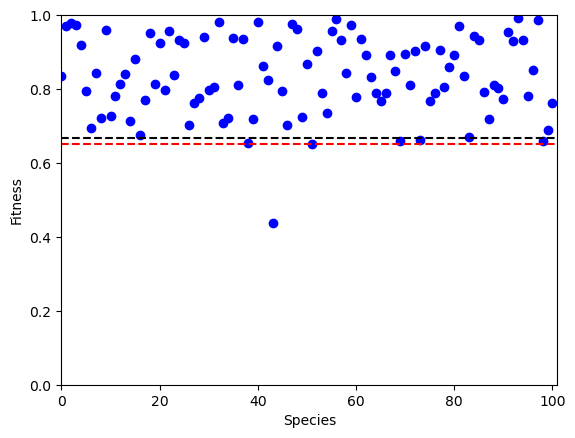

In [3]:
species_locations = [[x for x in range(0, n_species)]] * len(animation_list)
fps = 5
fig, ax = plt.subplots()

points, = ax.plot([], [], 'bo')
line_red, = ax.plot([], [], 'r--')  # red line plot for the simulation threshold
line_black, = ax.plot([], [], 'k--')  # black line plot for the critical threshold

ax.set_xlim(0, n_species)
ax.set_ylim(0, 1)
ax.set_xlabel("Species")
ax.set_ylabel("Fitness")

threshold = 0.65
threshold_theoretical = 0.667

def update(frame):
    # get values for the current frame
    y = animation_list[frame]
    x = species_locations[frame]
    points.set_data(x, y)

    # set black and red threshold lines
    line_red.set_data([0, n_species], [threshold, threshold])
    line_black.set_data([0, n_species], [threshold_theoretical, threshold_theoretical])

    return points, line_red, line_black

ani = animation.FuncAnimation(fig, update, frames=len(animation_list), interval=1000/fps)

ani.save('animation.gif', writer='pillow')

plt.show()

Local avalanche activity

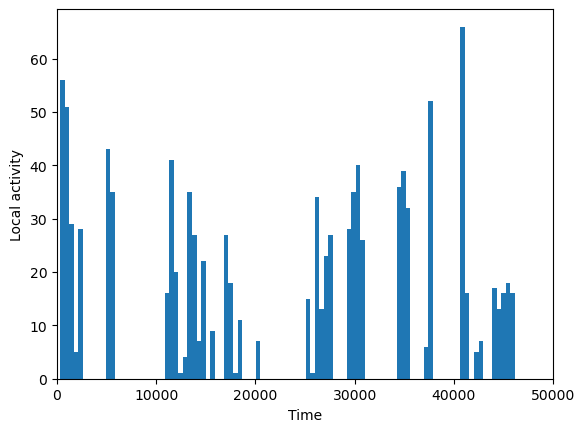

In [4]:
# plot avalanche activity in time
plt.hist(avalanche_activity_local, bins=100)
plt.xlim(0,n_iterations-skip_iterations)
plt.xlabel('Time')
plt.ylabel('Local activity')
plt.show()

Plot 1D gap function

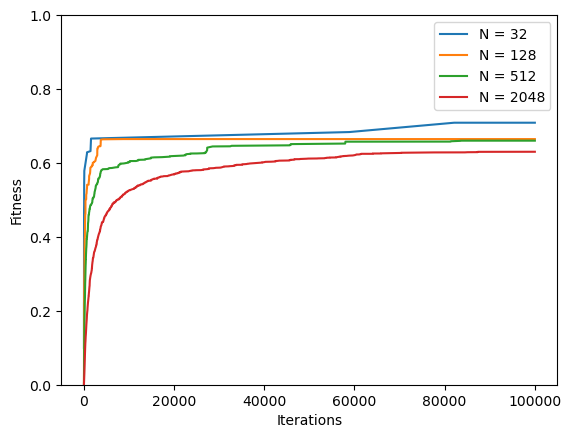

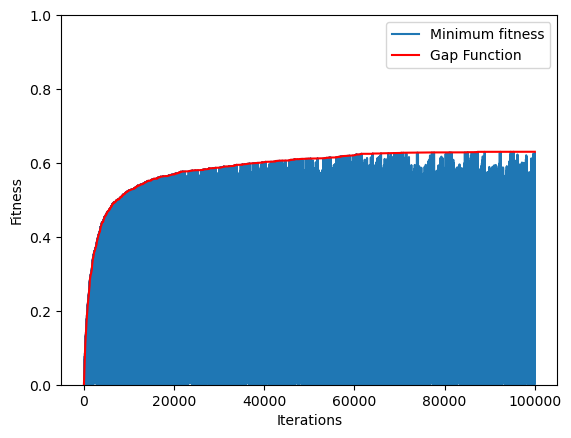

In [5]:
# run simulation for different system sizes to compare
system_sizes = [32, 128, 512, 2048]
local_segment = [0,20]
n_iterations = 100000
skip_iterations = 0
threshold = 0.65

min_fitness_list = []

for n_species in system_sizes:
    min_fitness, fitness_history, avalanche_sizes_global, avalanche_sizes_local, avalanche_activity_global, avalanche_activity_local, _ = bak_sneppen_1D(n_iterations, skip_iterations, n_species, threshold, local_segment)
    min_fitness_list.append(min_fitness)

plot_gap_function(min_fitness_list, n_iterations, skip_iterations, system_sizes)

Avalanche size distribution 1D, fit on the biggest system size

In [6]:
# run simulation for different system sizes to compare
system_sizes = [32, 128, 512, 2048]
n_iterations = 700000
skip_iterations = 200000
threshold = 0.65

avalanche_sizes_list = []

for n_species in system_sizes:
    min_fitness, fitness_history, avalanche_sizes_global, avalanche_sizes_local, avalanche_activity_global, avalanche_activity_local, _ = bak_sneppen_1D(n_iterations, skip_iterations, n_species, threshold, local_segment)
    avalanche_sizes_list.append(avalanche_sizes_global)


Exponent: -0.6845351232142713
Iterations: 700000


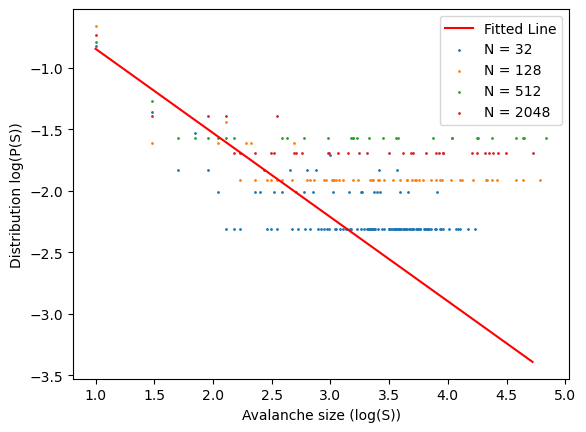

In [7]:
# for 1D we used: 
# threshold_skip = 70 for n_iterations = 1e6
# threshold_skip = 1000 for n_iterations = 1e7
# threshold_skip = 1000 for n_iterations = 1e8
threshold_skip = 100
legend_text = [f'N = {system_sizes[i]}' for i in range(len(system_sizes))]
plot_avalanche_dist(avalanche_sizes_list, bin_size=20, legend_text=legend_text, line=False, fit=True, n_iterations=n_iterations, threshold_skip=threshold_skip)

Threshold variation 1D

In [8]:
# run simulation for different system sizes to compare
thresholds = [x for x in np.arange(0.59, 0.65, 0.01)]
system_size = 250
n_iterations = 700000
skip_iterations = 200000
local_segment = [0,1]

count = 0
avalanche_sizes_list = []

for threshold in thresholds:
    min_fitness, fitness_history, avalanche_sizes_global, avalanche_sizes_local, avalanche_activity_global, avalanche_activity_local, _ = bak_sneppen_1D(n_iterations, skip_iterations, system_size, threshold, local_segment)
    avalanche_sizes_list.append(list(avalanche_sizes_global))

        

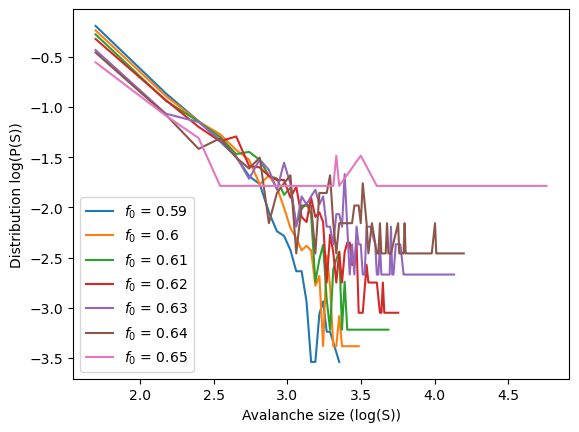

In [9]:
legend_text = [f'$f_0$ = {thresholds[i]}' for i in range(len(thresholds))]
plot_avalanche_dist(avalanche_sizes_list, bin_size=100, legend_text=legend_text, line=True, fit=False)

Gap function 2D

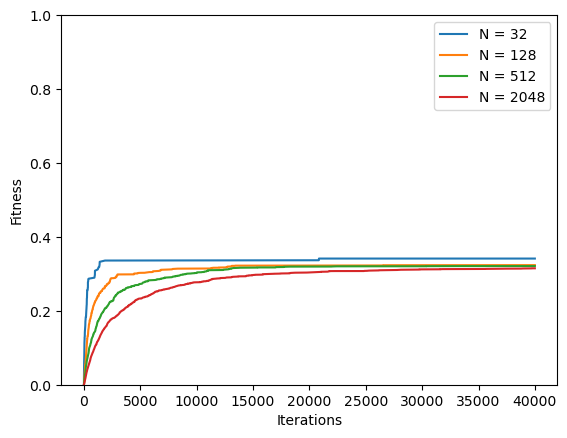

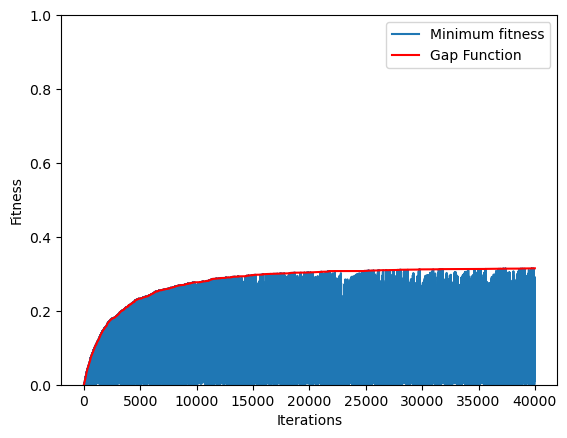

In [10]:
# run simulation for different system sizes to compare
grid_sizes = [20, 40, 60, 80]
# system_sizes = [50]

n_iterations = 40000
skip_iterations = 0
threshold = 0.32

min_fitness_list = []

for grid_size in grid_sizes:
    min_fitness, fitness_history, avalanche_sizes_global, avalanche_sizes_local, avalanche_activity_global, avalanche_activity_local = bak_sneppen_2D(n_iterations, skip_iterations, grid_size, threshold)
    min_fitness_list.append(min_fitness)

plot_gap_function(min_fitness_list, n_iterations, skip_iterations, system_sizes)

Avalanche size distribution 2D, fit on the biggest system size

In [11]:
# run simulation for different system sizes to compare
grid_sizes = [20, 40, 60, 80]
n_iterations = 700000
skip_iterations = 200000
threshold = 0.32

avalanche_sizes_list = []

for grid_size in grid_sizes:
    min_fitness, fitness_history, avalanche_sizes_global, avalanche_sizes_local, avalanche_activity_global, avalanche_activity_local = bak_sneppen_2D(n_iterations, skip_iterations, grid_size, threshold)
    avalanche_sizes_list.append(avalanche_sizes_global)

Exponent: -1.1862865543520442
Iterations: 700000


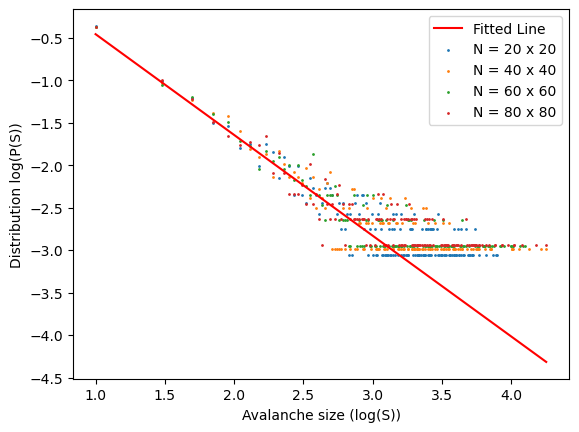

In [12]:
# for 2D we used: 
# threshold_skip = 1000 for n_iterations = 1e6
# threshold_skip = 5000 for n_iterations = 5e6
# threshold_skip = 9000 for n_iterations = 1e7
threshold_skip = 1000

legend_text = [f'N = {grid_sizes[i]} x {grid_sizes[i]}' for i in range(len(grid_sizes))]
plot_avalanche_dist(avalanche_sizes_list, bin_size=20, legend_text=legend_text, line=False, fit=True, n_iterations=n_iterations, threshold_skip=threshold_skip)

Threshold variation 2D

In [13]:
# run simulation for different system sizes to compare
thresholds_2D = [x for x in np.arange(0.25, 0.32, 0.01)]
grid_size = 80
n_iterations = 250000
skip_iterations = 50000

count = 0
avalanche_sizes_list = []
for threshold in thresholds_2D:
    min_fitness, fitness_history, avalanche_sizes_global, avalanche_sizes_local, avalanche_activity_global, avalanche_activity_local = bak_sneppen_2D(n_iterations, skip_iterations, grid_size, threshold)
    avalanche_sizes_list.append(list(avalanche_sizes_global))

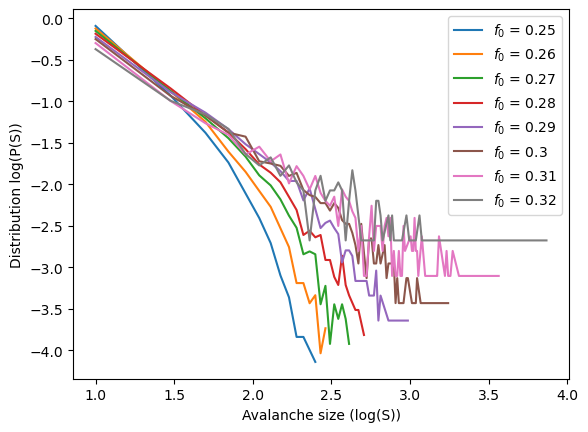

In [14]:
legend_text = [f'$f_0$ = {round(thresholds_2D[i],2)}' for i in range(len(thresholds_2D))]
plot_avalanche_dist(avalanche_sizes_list, bin_size=20, legend_text=legend_text, line=True, fit=False)